## Setting up environment

In [ ]:
import sys
import os
import json
import pandas as pd
import optparse
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

from keras.callbacks import TensorBoard
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from collections import OrderedDict
from keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow as tf
import tensorflow_addons as tfa

## Loading Data

In [ ]:
df = pd.read_csv('Bitcoin.csv')

In [ ]:
df.head(5)

,Date,Open,High,Low,Close,Volume,Currency
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800.0,USD
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200.0,USD
2,2014-09-19,424.102997,427.834992,384.532013,394.795990,37919700.0,USD
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600.0,USD
4,2014-09-21,408.084992,412.425995,393.181000,398.821014,26580100.0,USD


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2792 entries, 0 to 2791
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      2792 non-null   object 
 1   Open      2792 non-null   float64
 2   High      2792 non-null   float64
 3   Low       2792 non-null   float64
 4   Close     2792 non-null   float64
 5   Volume    2792 non-null   float64
 6   Currency  2792 non-null   object 
dtypes: float64(5), object(2)
memory usage: 152.8+ KB


## Feature Engineering

In [ ]:
df['Date']= pd.to_datetime(df['Date'])

In [ ]:
df['change'] = (df.High - df.Low)

df['Open-1'] = df.Open.shift(1)
df['increase'] = (df['Close'] - df['Open']) >= 0

In [ ]:
# df['change'] = np.log(df['change'])
# df['Open'] = np.log(df['Open'])

In [ ]:
df = df[(df['Date'] > '2017-05-07') & (df['Date'] <= '2022-04-30')]

In [ ]:
df.head()

,Date,Open,High,Low,Close,Volume,Currency,change,Open-1,increase
964,2017-05-08,1596.920044,1723.349976,1596.920044,1723.349976,1.340320e+09,USD,126.429932,1579.469971,True
965,2017-05-09,1723.890015,1833.489990,1716.300049,1755.359985,1.167920e+09,USD,117.189941,1596.920044,True
966,2017-05-10,1756.520020,1788.439941,1719.099976,1787.130005,9.157230e+08,USD,69.339965,1723.890015,True
967,2017-05-11,1780.369995,1873.930054,1755.349976,1848.569946,7.994900e+08,USD,118.580078,1756.520020,True
968,2017-05-12,1845.760010,1856.150024,1694.010010,1724.239990,7.409840e+08,USD,162.140014,1780.369995,False


In [ ]:
df.shape

(1819, 10)

In [ ]:
df.reset_index(inplace= True)

In [ ]:
scaler = MinMaxScaler()

## Train-Test Split

In [ ]:
data_training = df[df['Date'] < '2022-04-01'].copy()
data_test = df[df['Date'] >= '2022-04-01'].copy()

In [ ]:
data_training.head()

,index,Date,Open,High,Low,Close,Volume,Currency,change,Open-1,increase
0,964,2017-05-08,1596.920044,1723.349976,1596.920044,1723.349976,1.340320e+09,USD,126.429932,1579.469971,True
1,965,2017-05-09,1723.890015,1833.489990,1716.300049,1755.359985,1.167920e+09,USD,117.189941,1596.920044,True
2,966,2017-05-10,1756.520020,1788.439941,1719.099976,1787.130005,9.157230e+08,USD,69.339965,1723.890015,True
3,967,2017-05-11,1780.369995,1873.930054,1755.349976,1848.569946,7.994900e+08,USD,118.580078,1756.520020,True
4,968,2017-05-12,1845.760010,1856.150024,1694.010010,1724.239990,7.409840e+08,USD,162.140014,1780.369995,False


In [ ]:
training_data = data_training.drop(['Date', 'index', 'Close', 'Currency'], axis = 1)

In [ ]:
training_data.head()

,Open,High,Low,Volume,change,Open-1,increase
0,1596.920044,1723.349976,1596.920044,1.340320e+09,126.429932,1579.469971,True
1,1723.890015,1833.489990,1716.300049,1.167920e+09,117.189941,1596.920044,True
2,1756.520020,1788.439941,1719.099976,9.157230e+08,69.339965,1723.890015,True
3,1780.369995,1873.930054,1755.349976,7.994900e+08,118.580078,1756.520020,True
4,1845.760010,1856.150024,1694.010010,7.409840e+08,162.140014,1780.369995,False


In [ ]:
training_data = scaler.fit_transform(training_data)

In [ ]:
X_train = [] 
Y_train = []

In [ ]:
training_data.shape[0]

1789

In [ ]:
for i in range(60, training_data.shape[0]):
    X_train.append(training_data[i-60:i])
    Y_train.append(training_data[i,0])

In [ ]:
X_train, Y_train = np.array(X_train), np.array(Y_train)

In [ ]:
X_train.shape

(1729, 60, 7)

## Model

In [ ]:
model = Sequential()
model.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
model.add(Dropout(0.2))
model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units =1))

In [ ]:
model.compile(optimizer = 'adam', 
              loss = 'mean_squared_error',
              metrics=[tf.keras.metrics.RootMeanSquaredError(), tfa.metrics.RSquare()])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            11600     
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 60)            26640     
                                                                 
 dropout_1 (Dropout)         (None, 60, 60)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 80)            45120     
                                                                 
 dropout_2 (Dropout)         (None, 60, 80)            0         
                                                                 
 lstm_3 (LSTM)               (None, 120)               9

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

In [ ]:
%%time 
early_stopping_monitor = EarlyStopping(patience=3)

history= model.fit(X_train, Y_train, epochs = 20, batch_size =50, validation_split=0.1, callbacks=early_stopping_monitor)

Epoch 1/20
32/32 [==============================] - 16s 239ms/step - loss: 0.0224 - root_mean_squared_error: 0.1496 - r_square: 0.5629 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1059 - val_r_square: 0.3961
Epoch 2/20
32/32 [==============================] - 10s 327ms/step - loss: 0.0036 - root_mean_squared_error: 0.0601 - r_square: 0.9295 - val_loss: 0.0056 - val_root_mean_squared_error: 0.0749 - val_r_square: 0.6977
Epoch 3/20
32/32 [==============================] - 9s 283ms/step - loss: 0.0028 - root_mean_squared_error: 0.0525 - r_square: 0.9462 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1090 - val_r_square: 0.3604
Epoch 4/20
32/32 [==============================] - 6s 201ms/step - loss: 0.0030 - root_mean_squared_error: 0.0544 - r_square: 0.9421 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0991 - val_r_square: 0.4711
Epoch 5/20
32/32 [==============================] - 6s 200ms/step - loss: 0.0028 - root_mean_squared_error: 0.0530 - r_square: 0.9451 - val_lo

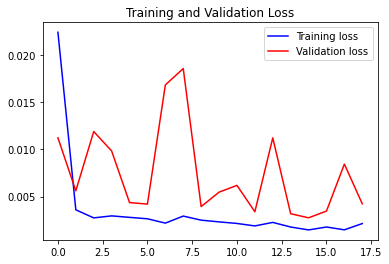

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

## Predictions on test data

In [ ]:
part_60_days = data_training.tail(60)
df_test= part_60_days.append(data_test, ignore_index = True)
df_test= df_test.drop(['Date', 'index', 'Close', 'Currency'], axis = 1)
df_test.head()

,Open,High,Low,Volume,change,Open-1,increase
0,37920.28125,38647.26172,36733.57422,2.073473e+10,1913.68750,38151.91797,True
1,38481.76563,39115.13281,38113.66406,2.028850e+10,1001.46875,37920.28125,True
2,38743.71484,38834.61719,36832.73047,1.915519e+10,2001.88672,38481.76563,False
3,36944.80469,37154.60156,36375.53906,1.859153e+10,779.06250,38743.71484,True
4,37149.26563,41527.78516,37093.62891,2.941221e+10,4434.15625,36944.80469,True


In [ ]:
inputs = scaler.transform(df_test)

In [ ]:
X_test = []
Y_test = []

In [ ]:
for i in range (60, inputs.shape[0]):
    X_test.append(inputs[i-60:i]) 
    Y_test.append(inputs[i, 0])

In [ ]:
X_test, Y_test = np.array(X_test), np.array(Y_test)
X_test.shape, Y_test.shape

((30, 60, 7), (30,))

In [ ]:
Y_pred = model.predict(X_test)
Y_pred, Y_test

(array([[0.6766064 ],
        [0.6828208 ],
        [0.68526137],
        [0.6865562 ],
        [0.68821985],
        [0.68824613],
        [0.68559617],
        [0.6823629 ],
        [0.6771374 ],
        [0.6719527 ],
        [0.66543794],
        [0.6569471 ],
        [0.64859915],
        [0.64177   ],
        [0.63478166],
        [0.62905097],
        [0.6229847 ],
        [0.6158293 ],
        [0.60956025],
        [0.6054437 ],
        [0.60185003],
        [0.5977011 ],
        [0.59231853],
        [0.5855124 ],
        [0.57742786],
        [0.5705174 ],
        [0.56397337],
        [0.55944574],
        [0.5578768 ],
        [0.5573008 ]], dtype=float32),
 array([0.66649535, 0.67758412, 0.67111933, 0.68000667, 0.68272428,
        0.66634663, 0.6309144 , 0.63542727, 0.61688282, 0.62444901,
        0.61565408, 0.57521116, 0.58415476, 0.59987279, 0.58136234,
        0.59065556, 0.58861563, 0.57805392, 0.59483824, 0.60505115,
        0.60307655, 0.59025447, 0.57831956, 0.57437

In [ ]:
scale = 1/scaler.scale_[0]
scale

Y_pred = Y_pred * scale
Y_test = Y_test * scale

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

rmse = mean_squared_error(Y_test, Y_pred, squared=False)
r2 = r2_score(Y_test, Y_pred)

rmse, r2

(2271.8936617688764, 0.18166904717091303)

In [ ]:
def calculate_smape(actual, predicted) -> float:
  
    # Convert actual and predicted to numpy
    # array data type if not already
    if not all([isinstance(actual, np.ndarray), 
                isinstance(predicted, np.ndarray)]):
        actual, predicted = np.array(actual),
        np.array(predicted)
  
    return round(
        np.mean(
            np.abs(predicted - actual) / 
            ((np.abs(predicted) + np.abs(actual))/2)
        )*100, 2
    )

calculate_smape(Y_test, Y_pred)

8.4

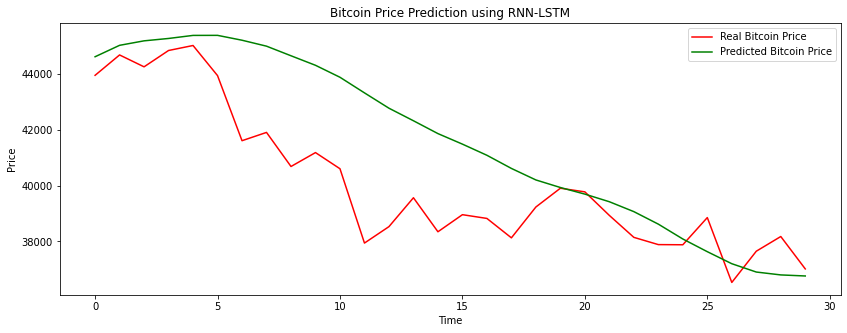

In [ ]:
plt.figure(figsize=(14,5))
plt.plot(Y_test, color = 'red', label = 'Real Bitcoin Price')
plt.plot(Y_pred, color = 'green', label = 'Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction using RNN-LSTM')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()